In [1]:
!pip install -q ultralytics imutils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.8 MB/s eta 0:00:00


In [2]:
from tqdm.auto import tqdm

import os
import requests
import zipfile
import cv2
import math
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

from PIL import Image

In [3]:
ROOT_DIR = '/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav'
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'
val_imgs_dir = 'images/val'
val_labels_dir = 'labels/val'
test_imgs_dir = 'images/test'
test_labels_dir = 'labels/test'
classes = ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [4]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [5]:
def plot_box(image, bboxes, labels, classes=classes, colors=colors, pos='above'):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    height, width, _ = image.shape
    lw = max(round(sum(image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*width)
        ymin = int(y1*height)
        xmax = int(x2*width)
        ymax = int(y2*height)

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        
        class_name = classes[int(labels[box_num])]

        color=colors[classes.index(class_name)]
        
        cv2.rectangle(
            image, 
            p1, p2,
            color=color, 
            thickness=lw,
            lineType=cv2.LINE_AA
        ) 

        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name, 
            0, 
            fontScale=lw / 3, 
            thickness=tf
        )[0]

        outside = p1[1] - h >= 3
        
        if pos == 'above':
            p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
            cv2.rectangle(
                image, 
                p1, p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                image, 
                class_name, 
                (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw/3.5, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
        else:
            new_p2 = p1[0] + w, p2[1] + h + 3 if outside else p2[1] - h - 3
            cv2.rectangle(
                image, 
                (p1[0], p2[1]), new_p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                image, 
                class_name, 
                (p1[0], p2[1] + h + 2 if outside else p2[1]),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw/3, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
    return image

In [6]:
# Function to plot images with the bounding boxes.
def plot(image_path, label_path, num_samples, classes=classes, colors=colors, pos='above'):
    all_training_images = glob.glob(image_path+'/*')
    all_training_labels = glob.glob(label_path+'/*')
    all_training_images.sort()
    all_training_labels.sort()
    
    temp = list(zip(all_training_images, all_training_labels))
    random.shuffle(temp)
    all_training_images, all_training_labels = zip(*temp)
    all_training_images, all_training_labels = list(all_training_images), list(all_training_labels)
    
    num_images = len(all_training_images)
    
    if num_samples == -1:
        num_samples = num_images
    
    num_cols = 2
    num_rows = int(math.ceil(num_samples / num_cols))
        
    plt.figure(figsize=(10 * num_cols, 6 * num_rows))
    for i in range(num_samples):
        image_name = all_training_images[i].split(os.path.sep)[-1]
        image = cv2.imread(all_training_images[i])
        with open(all_training_labels[i], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label, x_c, y_c, w, h = label_line.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels, classes, colors, pos)
        plt.subplot(num_rows, num_cols, i+1) # Visualize 2x2 grid of images.
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

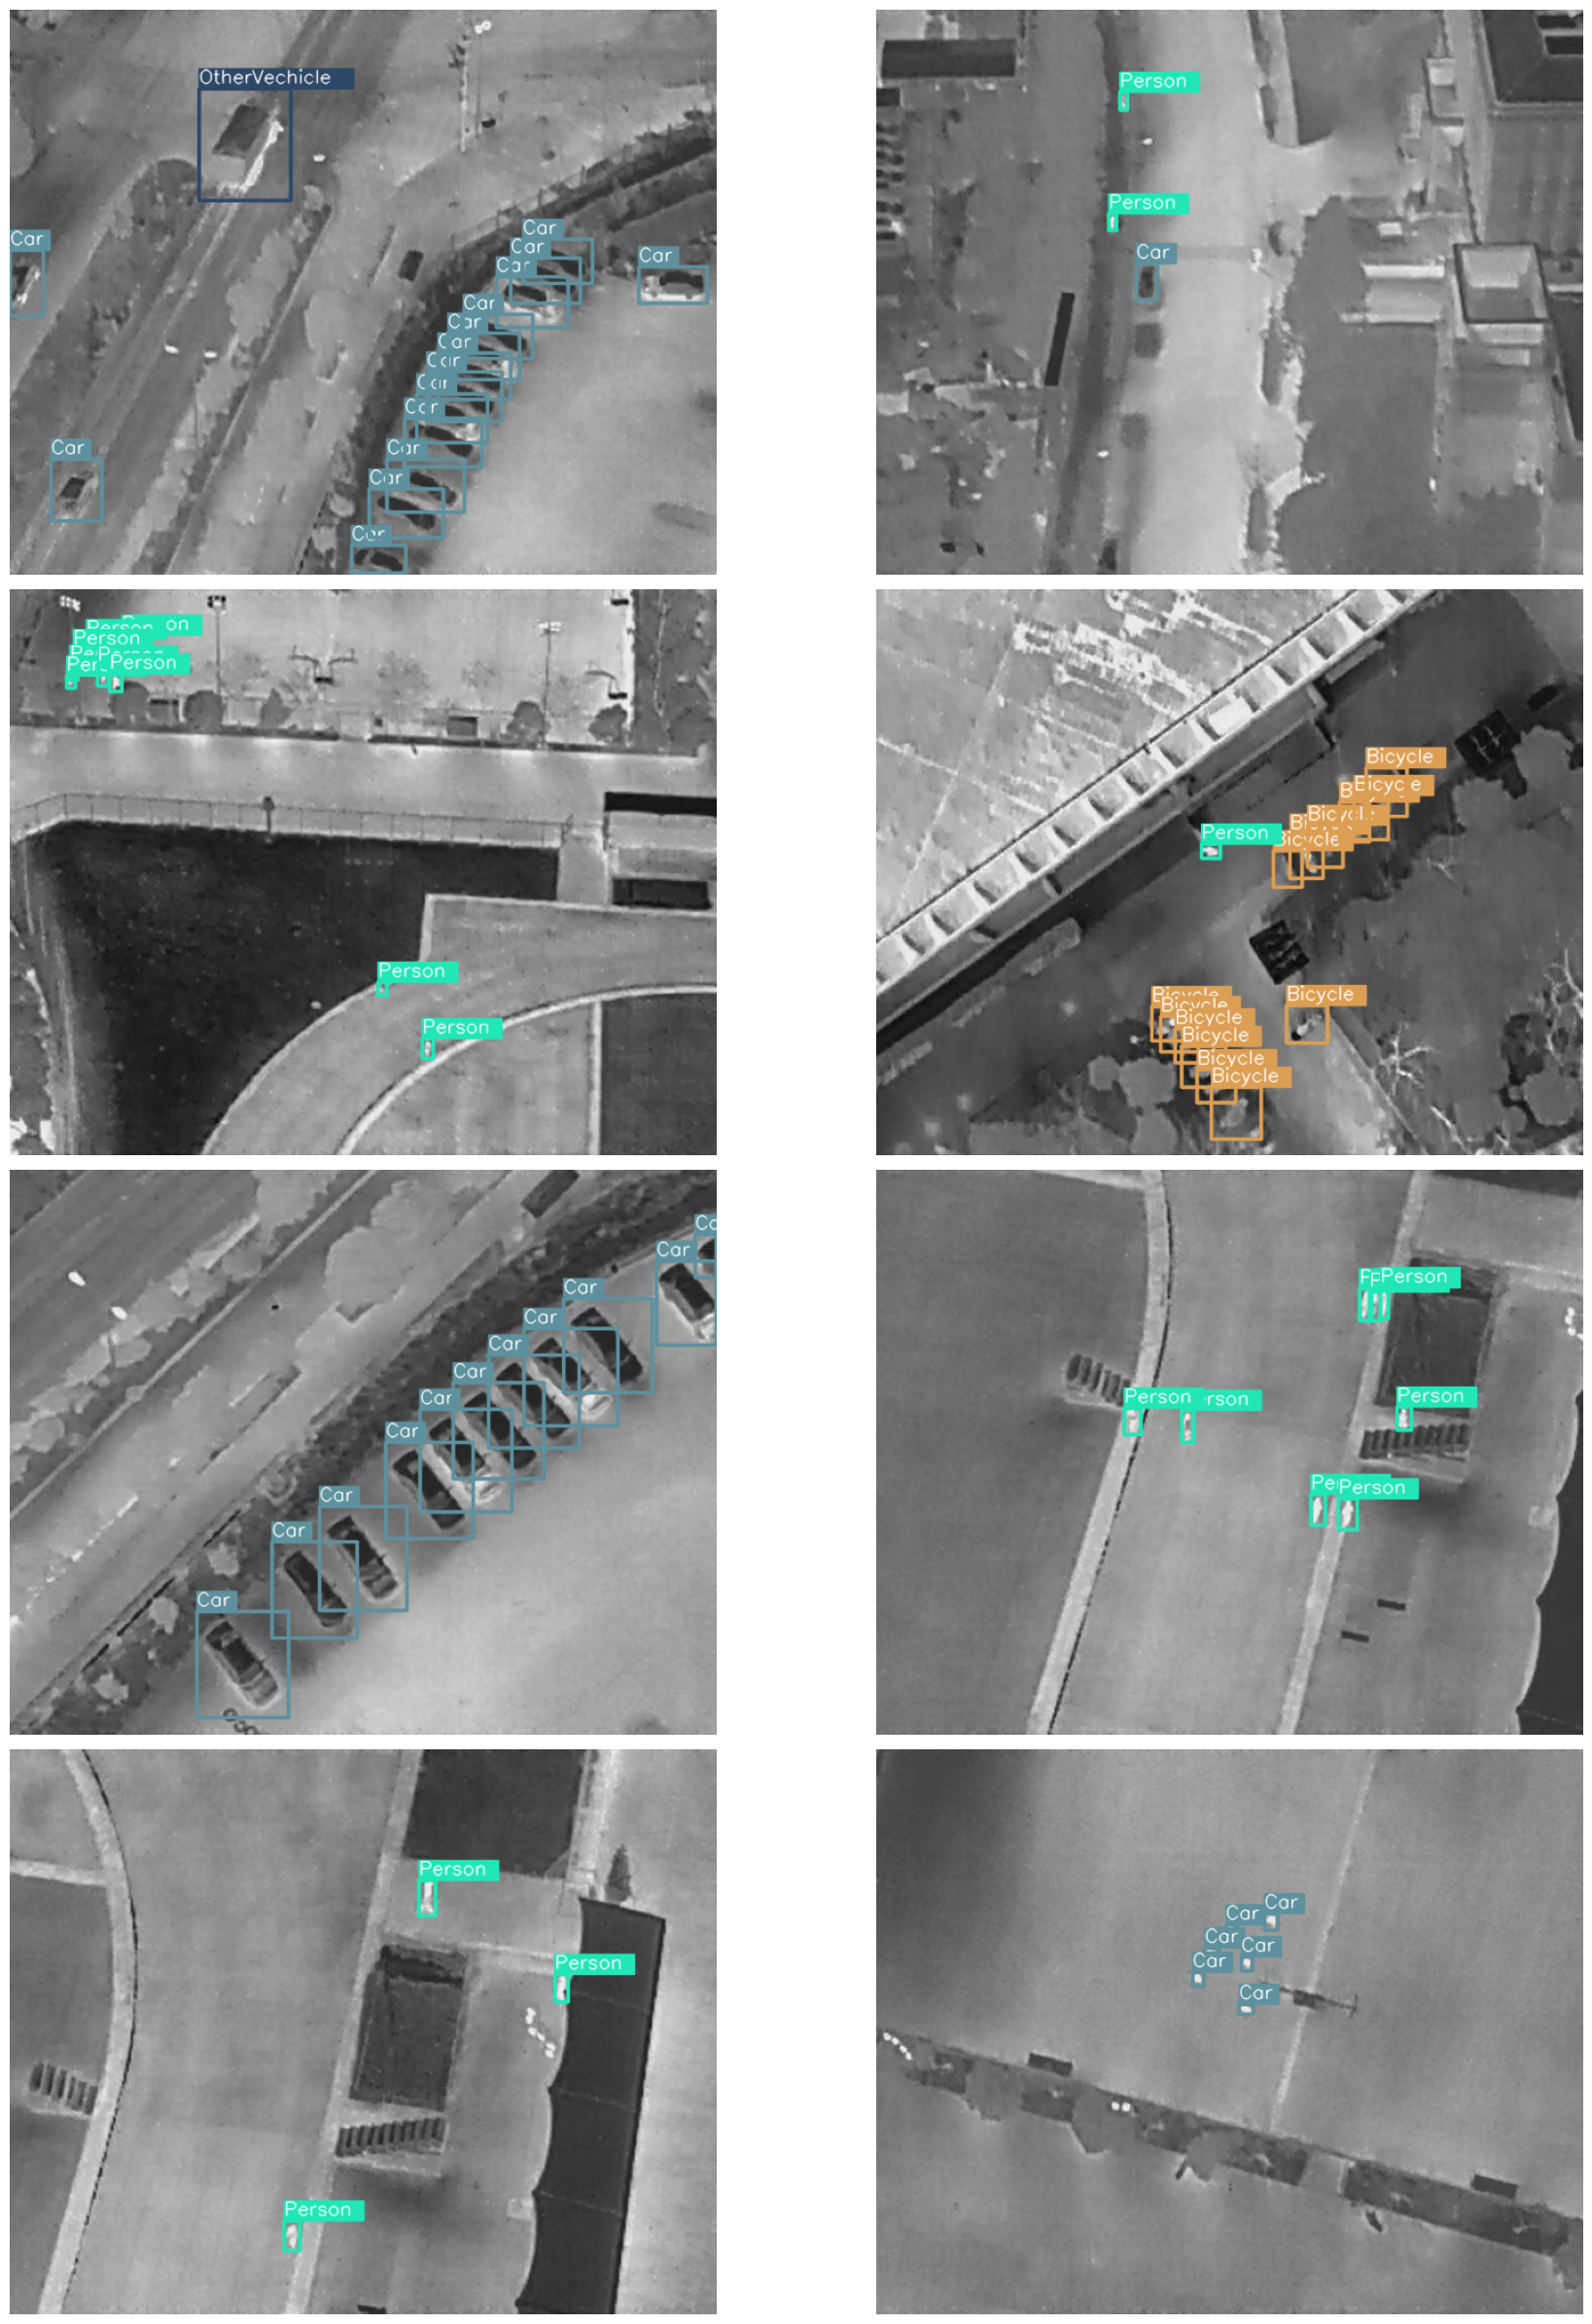

In [7]:
# Visualize a few training images.
plot(
    image_path=os.path.join(ROOT_DIR, train_imgs_dir), 
    label_path=os.path.join(ROOT_DIR, train_labels_dir),
    num_samples=8
)

In [8]:
import yaml

# data.yaml oluşturma
data_dict = {
    "train": "/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/train",
    "val": "/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/val",
    "test": "/kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test",
    "nc": 5,
    "names": ['Person', 'Car', 'Bicycle', 'OtherVehicle', 'DontCare']
}

with open("dataset.yaml", "w") as f:
    yaml.dump(data_dict, f, sort_keys=False)




In [9]:
import yaml
import os

all_models = {
    "efficientnet_b0_yolov8": {
        "nc": 5,
        "backbone": [
            [-1, 1, "TorchVision", [1280, "efficientnet_b0", "DEFAULT", True, 2, True]],
            [-1, 1, "nn.Identity", []],
            [-1, 1, "nn.Identity", []],
            [0, 1, "Index", [40, 4]],
            [-1, 1, "Conv", [256, 1, 1]],
            [-1, 1, "nn.Identity", []],
            [0, 1, "Index", [112, 6]],
            [-1, 1, "Conv", [512, 1, 1]],
            [-1, 1, "nn.Identity", []],
            [0, 1, "Index", [1280, 9]],
            [-1, 1, "Conv", [1024, 1, 1]],
            [-1, 1, "SPPF", [1024, 5]]
        ],
        "head": [
            [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
            [[-1, 6], 1, "Concat", [1]],
            [-1, 3, "C2f", [512, True]],
            [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
            [[-1, 4], 1, "Concat", [1]],
            [-1, 3, "C2f", [256, True]],
            [-1, 1, "Conv", [256, 3, 2]],
            [[-1, 12], 1, "Concat", [1]],
            [-1, 3, "C2f", [512, True]],
            [-1, 1, "Conv", [512, 3, 2]],
            [[-1, 9], 1, "Concat", [1]],
            [-1, 3, "C2f", [1024, True]],
            [[17, 20, 23], 1, "Detect", ["nc"]]
        ]
    },

    "efficientnet_b0_yolov10": {
        "nc": 5,
        "backbone": [
            # EfficientNet-B0 backbone
            [-1, 1, "TorchVision", [1280, "efficientnet_b0", "DEFAULT", True, 1, True]],

            # P3 (stage2 output = 24 channels)
            [0, 1, "Index", [24, 2]],
            [-1, 1, "Conv", [256, 1, 1]],

            # P4 (stage3 output = 40 channels)
            [0, 1, "Index", [40, 4]],
            [-1, 1, "Conv", [512, 1, 1]],

            # P5 (stage5 output = 112 channels)
            [0, 1, "Index", [112, 6]],
            [-1, 1, "Conv", [1024, 1, 1]],
            [-1, 1, "SPPF", [1024, 5]]
        ],

        "head": [
            # P5 → P4
            [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
            [[-1, 4], 1, "Concat", [1]],
            [-1, 3, "C2PSA", [512, True]],

            # P4 → P3
            [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
            [[-1, 2], 1, "Concat", [1]],
            [-1, 3, "C2PSA", [256, True]],

            # Dynamic aggregation
            [-1, 1, "DynamicHead", [1024]],

            # Detect head
            [[12, 9, 6], 1, "Detect", ["nc"]]
        ]
    },


    "efficientnet_b3_yolov8": {
        "nc": 5,
        "backbone": [
            [-1, 1, "TorchVision", [1536, "efficientnet_b3", "DEFAULT", True, 2, True]],
            [-1, 1, "nn.Identity", []],
            [-1, 1, "nn.Identity", []],
            [0, 1, "Index", [48, 4]],
            [-1, 1, "Conv", [256, 1, 1]],
            [-1, 1, "nn.Identity", []],
            [0, 1, "Index", [136, 6]],
            [-1, 1, "Conv", [512, 1, 1]],
            [-1, 1, "nn.Identity", []],
            [0, 1, "Index", [1536, 9]],
            [-1, 1, "Conv", [1024, 1, 1]],
            [-1, 1, "SPPF", [1024, 5]]
        ],
        "head": [
            [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
            [[-1, 6], 1, "Concat", [1]],
            [-1, 3, "C2f", [512, True]],
            [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
            [[-1, 4], 1, "Concat", [1]],
            [-1, 3, "C2f", [256, True]],
            [-1, 1, "Conv", [256, 3, 2]],
            [[-1, 12], 1, "Concat", [1]],
            [-1, 3, "C2f", [512, True]],
            [-1, 1, "Conv", [512, 3, 2]],
            [[-1, 9], 1, "Concat", [1]],
            [-1, 3, "C2f", [1024, True]],
            [[17, 20, 23], 1, "Detect", ["nc"]]
        ]
    },

    "efficientnet_b3_yolov10": {
        "nc": 5,
        "backbone": [
            [-1, 1, "TorchVision", [1536, "efficientnet_b3", "DEFAULT", True, 2, True]],
            [-1, 1, "nn.Identity", []],
            [-1, 1, "nn.Identity", []],
            [0, 1, "Index", [48, 4]],
            [-1, 1, "Conv", [256, 1, 1]],
            [-1, 1, "nn.Identity", []],
            [0, 1, "Index", [136, 6]],
            [-1, 1, "Conv", [512, 1, 1]],
            [-1, 1, "nn.Identity", []],
            [0, 1, "Index", [1536, 9]],
            [-1, 1, "Conv", [1024, 1, 1]],
            [-1, 1, "SPPF", [1024, 5]]
        ],
        "head": [
            [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
            [[-1, 6], 1, "Concat", [1]],
            [-1, 3, "C2PSA", [512, True]],
            [-1, 1, "nn.Upsample", [None, 2, "nearest"]],
            [[-1, 4], 1, "Concat", [1]],
            [-1, 3, "C2PSA", [256, True]],
            [-1, 1, "DynamicHead", [1024]],
            [[17, 20, 23], 1, "Detect", ["nc"]]
        ]
    }
}

yaml_path = "/kaggle/working/models.yaml"

if os.path.exists(yaml_path):
    os.remove(yaml_path)

with open(yaml_path, "w") as f:
    yaml.dump(all_models, f, sort_keys=False)

print("Saved to:", yaml_path)


Saved to: /kaggle/working/models.yaml


In [10]:
import yaml
from ultralytics import YOLO

with open('/kaggle/working/models.yaml') as f:
    models = yaml.safe_load(f)

model = all_models["efficientnet_b3_yolov8"]

with open('/kaggle/working/models.yaml', 'w') as f:
    yaml.dump(model, f)

yolo_efficientnet_model = YOLO('/kaggle/working/models.yaml')



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 201MB/s]


In [11]:
yolo_efficientnet_train = yolo_efficientnet_model.train(data="/kaggle/working/dataset.yaml", epochs=50, batch = 8)

Ultralytics 8.3.232 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/working/models.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspec

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        287       2460       0.82      0.737      0.787       0.53
                Person        171       1168      0.921      0.844      0.911       0.51
                   Car        136        719      0.949      0.976      0.987      0.768
               Bicycle         53        554      0.909      0.827      0.922      0.551
          OtherVehicle          9         12      0.831       0.75      0.793      0.695
              DontCare          5          7      0.491      0.286      0.322      0.126
Speed: 0.2ms preprocess, 18.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/train


In [12]:
!ls -l /kaggle/working/runs/detect/

total 4
drwxr-xr-x 3 root root 4096 Nov 25 15:10 train


In [13]:
best_efficientnet_model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

In [14]:
from imutils import paths

log_dir = "/kaggle/working/runs/detect/train4"
for image_path in sorted(paths.list_images(log_dir)):
    image = Image.open(image_path)
    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.title(os.path.basename(image_path))
    plt.axis('off')
    plt.show()

In [15]:
!zip -r /kaggle/working/runs.zip runs/

  adding: runs/ (stored 0%)
  adding: runs/detect/ (stored 0%)
  adding: runs/detect/train/ (stored 0%)
  adding: runs/detect/train/BoxF1_curve.png (deflated 7%)
  adding: runs/detect/train/val_batch0_pred.jpg (deflated 5%)
  adding: runs/detect/train/train_batch2.jpg (deflated 5%)
  adding: runs/detect/train/results.csv (deflated 61%)
  adding: runs/detect/train/val_batch2_labels.jpg (deflated 8%)
  adding: runs/detect/train/val_batch1_pred.jpg (deflated 7%)
  adding: runs/detect/train/train_batch10042.jpg (deflated 13%)
  adding: runs/detect/train/BoxR_curve.png (deflated 10%)
  adding: runs/detect/train/labels.jpg (deflated 27%)
  adding: runs/detect/train/train_batch1.jpg (deflated 5%)
  adding: runs/detect/train/val_batch1_labels.jpg (deflated 8%)
  adding: runs/detect/train/weights/ (stored 0%)
  adding: runs/detect/train/weights/last.pt (deflated 9%)
  adding: runs/detect/train/weights/best.pt (deflated 9%)
  adding: runs/detect/train/confusion_matrix.png (deflated 25%)
  adding

In [16]:
!ls -lh /kaggle/working/


total 209M
-rw-r--r-- 1 root root  325 Nov 25 12:49 dataset.yaml
-rw-r--r-- 1 root root 1.2K Nov 25 12:49 models.yaml
---------- 1 root root 6.5M Nov 25 15:10 __notebook__.ipynb
drwxr-xr-x 3 root root 4.0K Nov 25 12:49 runs
-rw-r--r-- 1 root root 197M Nov 25 15:10 runs.zip
-rw-r--r-- 1 root root 5.4M Nov 25 12:49 yolo11n.pt


# Inference on Test Images


In [17]:
results = best_efficientnet_model(os.path.join(ROOT_DIR, test_imgs_dir), conf=0.5, agnostic_nms=True, iou=0.5, save=True)


image 1/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_03307.jpg: 512x640 1 Person, 10 Cars, 67.9ms
image 2/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_08074.jpg: 512x640 7 Cars, 2 OtherVehicles, 27.1ms
image 3/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_08091.jpg: 512x640 12 Cars, 1 OtherVehicle, 26.6ms
image 4/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_30_0_08100.jpg: 512x640 2 Cars, 26.3ms
image 5/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_40_0_03327.jpg: 512x640 3 Persons, 26.4ms
image 6/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_40_0_03332.jpg: 512x640 3 Persons, 26.3ms
image 7/571 /kaggle/input/hituav-a-highaltitude-infrared-thermal-dataset/hit-uav/images/test/0_100_40_0_03342.jpg: 512x6

In [18]:
import random
import matplotlib.pyplot as plt

def show_random_result(results):
    random_result = random.choice(results)   
    img = random_result.plot()               

    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.show()




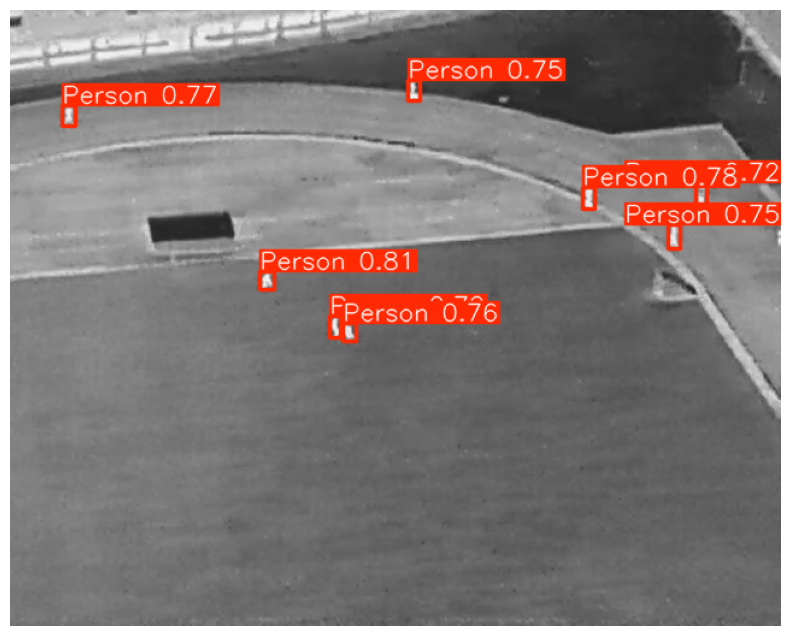

In [19]:
show_random_result(results)

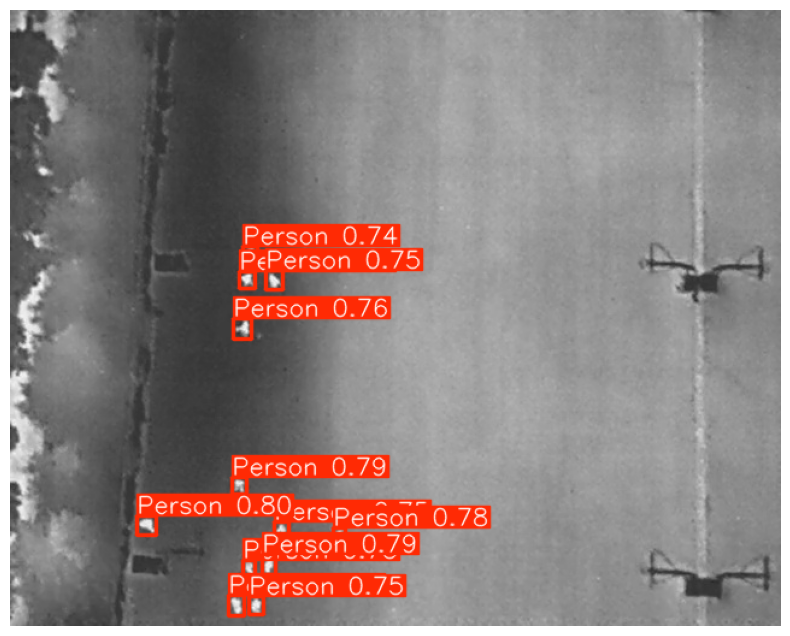

In [20]:
show_random_result(results)

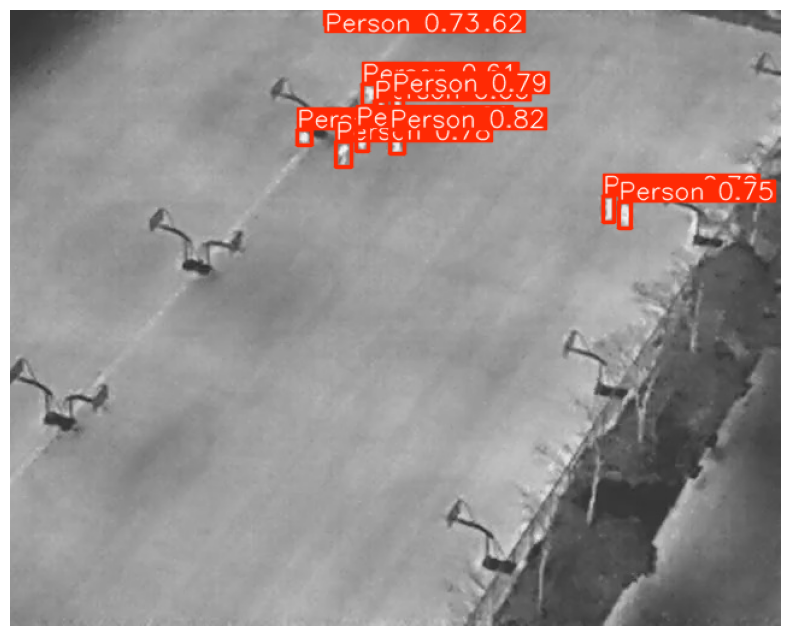

In [21]:

show_random_result(results)

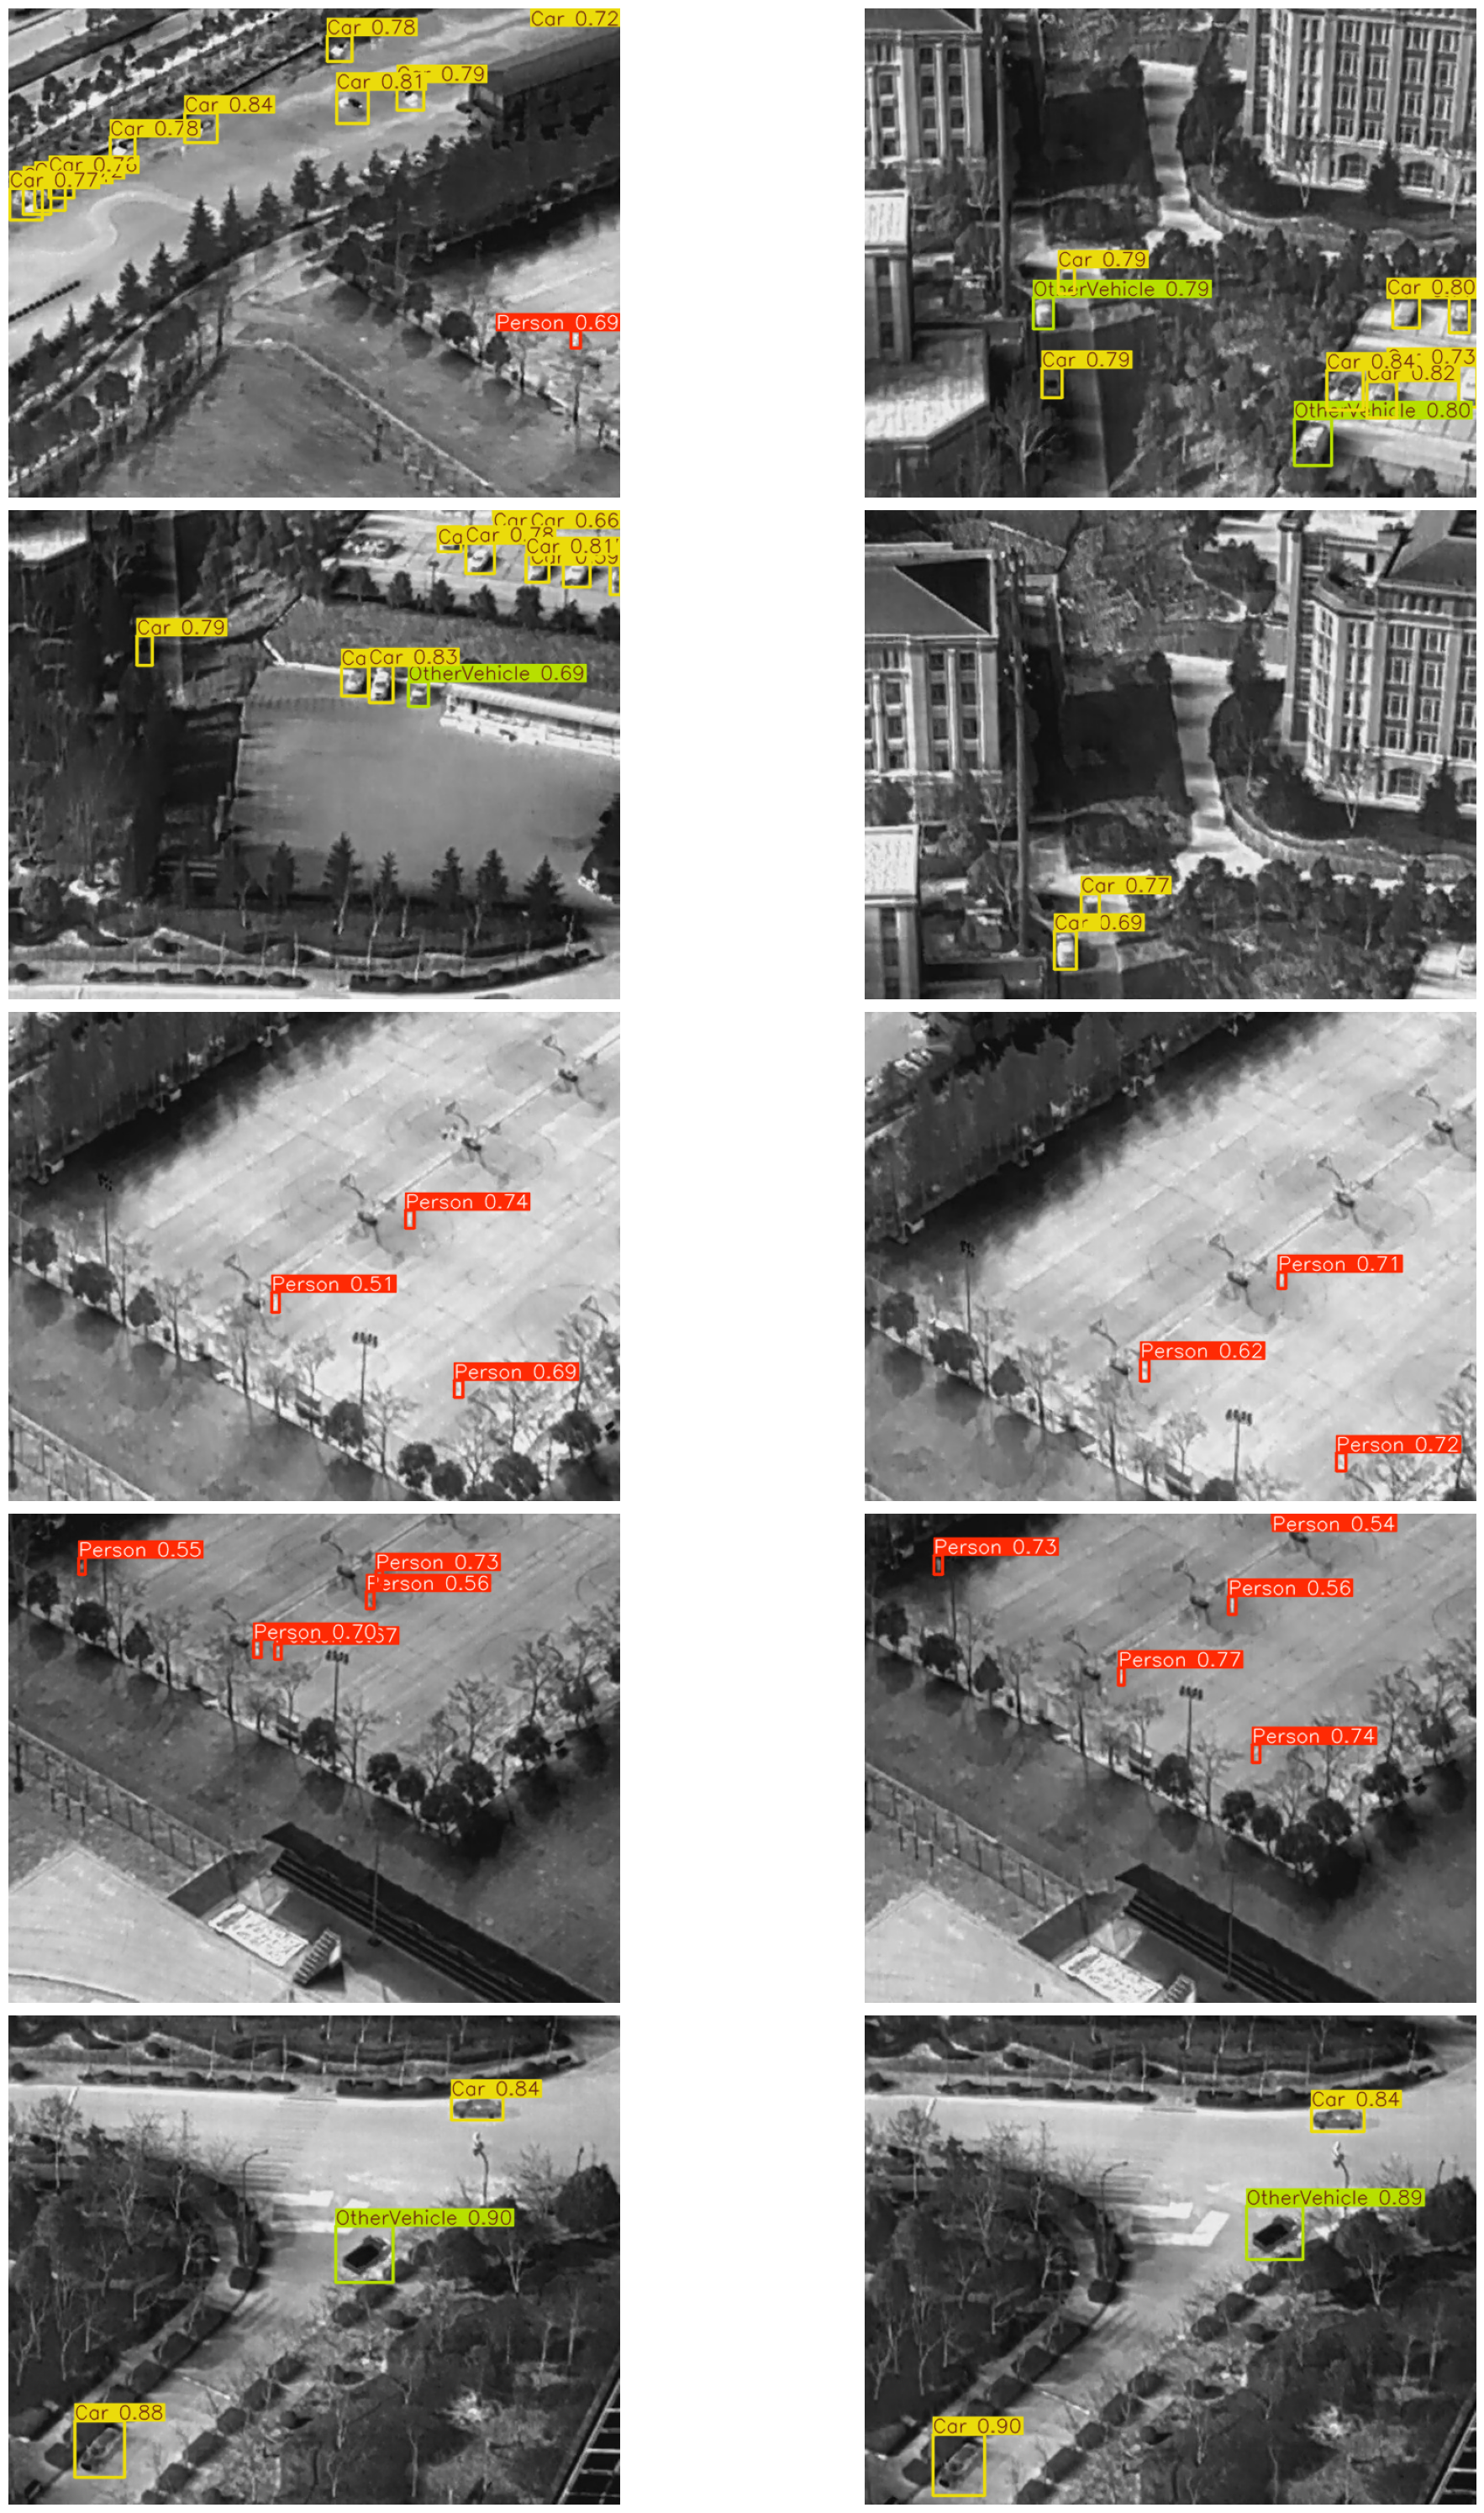

In [22]:
indices = list(range(len(results)))
random_indices = random.sample(indices, 10)
num_cols = 2
num_rows = 5

plt.figure(figsize=(12 * num_cols, 6 * num_rows))
    
for i, idx in enumerate(random_indices):
    image = results[i].plot()
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()
plt.show()


# Compare predictions with ground truth

In [23]:
ground_colors = [(255, 0, 0) for _ in range(len(classes))]

In [24]:
!ls runs/detect

predict  train


In [25]:
success = best_efficientnet_model.export(format="onnx")  # export the model to ONNX format
success

Ultralytics 8.3.232 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
models summary: 437 layers, 54,753,927 parameters, 0 gradients, 114.6 GFLOPs

PyTorch: starting from '/kaggle/working/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9, 8400) (105.1 MB)
requirements: Ultralytics requirements ['onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.11.13 environment at: /usr
Resolved 25 packages in 287ms
 Downloaded sympy
 Downloaded onnxruntime-gpu
Prepared 6 packages in 3.45s
Uninstalled 2 packages in 130ms
Installed 6 packages in 40ms
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnxruntime-gpu==1.23.2
 + onnxslim==0.1.75
 - protobuf==3.20.3
 + protobuf==6.33.1
 - sympy==1.13.1
 + sympy==1.14.0

requirements: AutoUpdate success ✅ 4.3s
WARNI

'/kaggle/working/runs/detect/train/weights/best.onnx'